Jupyter notebook for project

NLP applied to Kaggle dataset
Dataset here:
https://www.kaggle.com/datasets/stackoverflow/stacksample

Relevant NLP example:
https://github.com/Idilismiguzel/NLP-with-Python/blob/master/Text-Classification.ipynb

Possible BERT reference:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

## Read in the data (part of it) and just look at it for a bit

In [3]:
questions = pd.read_csv("archive/Questions.csv", encoding = "ISO-8859-1", nrows=5000)
#answers = pd.read_csv("archive/Answers.csv", encoding = "ISO-8859-1", nrows=5000)
#tags = pd.read_csv("archive/Tags.csv", encoding = "ISO-8859-1", nrows=5000)

In [4]:
questions.sample(5, random_state=234)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
2439,194650,1384652.0,2008-10-11T21:08:57Z,NaN,7,2D Javascript array,"<p>Simply put, is there a way to create a 2D j..."
4573,326770,39975.0,2008-11-28T22:07:18Z,NaN,5,How can I dynamically get the set of classes f...,<p>I have a python module that defines a numbe...
2152,174380,25492.0,2008-10-06T13:55:30Z,NaN,3,Spring webflow : Move through view states,"<p>Within a spring webflow, i need to implemen..."
3689,274770,12252.0,2008-11-08T14:24:31Z,NaN,0,Session is lost with login control in Internet...,<p>After logging in using the Login control th...
3853,284090,6091.0,2008-11-12T14:26:00Z,NaN,5,How to get a ReadOnlyCollection<T> of the Keys...,"<p>My class contains a <code>Dictionary&lt;T, ..."


In [5]:
print(questions.iloc[2439].Body)

<p>Simply put, is there a way to create a 2D javascript array using similar syntax to this?</p>

<pre><code>var newArray = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8]
]
</code></pre>



In [112]:
#answers.sample(5,random_state=505)

In [113]:
#print(answers.iloc[4162].Body)

In [114]:
#tags.sample(5, random_state=23)

## Confirm we actually read in as many rows as we thought, then count how many of those questions have been closed

In [6]:
np.shape(questions)[0]

5000

In [7]:
count = 0
for i in range(0,np.shape(questions)[0]):
    if pd.isna(questions.iloc[i].ClosedDate):
        count = count+1
        
print(count)

4618


In [8]:
np.shape(questions)[0] - count

382

In [9]:
questions['Closed'] = 1
for i in range(0,np.shape(questions)[0]):
    if pd.isna(questions.iloc[i].ClosedDate):
        questions['Closed'].iloc[i] = 0

questions.head(5)

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Closed
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,0
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,1
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,0
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,0
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,0


## Start looking at the scores. How many of these first 5000 questions have what score?

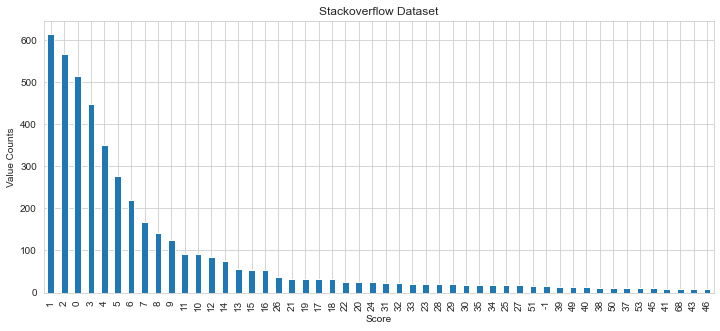

In [10]:
ax = questions['Score'].value_counts()[0:50].plot(kind='bar', figsize=(12,5))
fig = ax.get_figure()
ax.set_title("Stackoverflow Dataset")
ax.set_xlabel('Score')
ax.set_ylabel('Value Counts');

In [11]:
totals = questions['Score'].value_counts()

numbers = 0
for i in range(0,np.shape(totals)[0]):
    numbers = numbers + totals.iloc[i]

print(numbers)

5000


In [12]:
np.shape(totals)

(259,)

In [13]:
print(totals)

1       615
2       566
0       515
3       448
4       350
       ... 
114       1
192       1
446       1
367       1
5190      1
Name: Score, Length: 259, dtype: int64


## Find average score for this subset of data

In [14]:
print("Sum of scores for these questions is:", questions['Score'].sum())
print("Total number of questions is:", np.shape(questions)[0])
print("Number of unique score values is:", np.shape(totals)[0])

Sum of scores for these questions is: 120757
Total number of questions is: 5000
Number of unique score values is: 259


In [15]:
print("Mean of these scores is:", questions['Score'].mean())
print("Manual check of that mean:", questions['Score'].sum()/np.shape(questions)[0])
print("Median of these scores is:", questions['Score'].median())

Mean of these scores is: 24.1514
Manual check of that mean: 24.1514
Median of these scores is: 4.0


## Is there a connection between "closed" and "score"?

In [16]:
open_questions = questions[pd.isna(questions['ClosedDate'])].copy()
np.shape(open_questions)[0]

4618

In [17]:
closed_questions = questions[pd.notna(questions['ClosedDate'])].copy()
np.shape(closed_questions)[0]

382

In [18]:
print("Sum of scores for these open questions is:", open_questions['Score'].sum())
print("Total number of open questions is:", np.shape(open_questions)[0])
print("Number of unique score values is:", np.shape(open_questions['Score'].value_counts())[0])
print("Mean of these open question scores is:", open_questions['Score'].mean())
print("Median of these open question scores is:", open_questions['Score'].median())

Sum of scores for these open questions is: 107110
Total number of open questions is: 4618
Number of unique score values is: 246
Mean of these open question scores is: 23.19402338674751
Median of these open question scores is: 4.0


In [19]:
print("Sum of scores for these closed questions is:", closed_questions['Score'].sum())
print("Total number of closed questions is:", np.shape(closed_questions)[0])
print("Number of unique score values is:", np.shape(closed_questions['Score'].value_counts())[0])
print("Mean of these closed question scores is:", closed_questions['Score'].mean())
print("Median of these closed question scores is:", closed_questions['Score'].median())

Sum of scores for these closed questions is: 13647
Total number of closed questions is: 382
Number of unique score values is: 101
Mean of these closed question scores is: 35.725130890052355
Median of these closed question scores is: 9.5


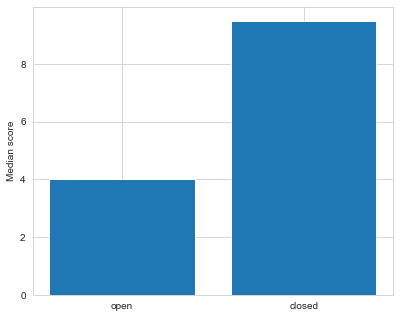

In [20]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])
status = ['open', 'closed']
values = [open_questions['Score'].median(),closed_questions['Score'].median()]
ax.bar(status, values)
ax.set_ylabel("Median score")
plt.show()

So maybe there's a correlation between whether a question is closed/open and its score. That is, here at least, closed questions have a higher median score than open questions. Thus we should determine what properties of a question (the actual words) lead to a question becoming closed.

## Switching to see if nltk works better for us

In [21]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

In [22]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [23]:
#def striphtml(data):
#    p = re.compile(r'<.*?>')
#    result = re.sub(r'<.*?>', '', data)
#    return result

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'<p>','', text)
    text = re.sub(r'</p>','', text)
    text = re.sub(r'\n','', text)
    text = re.sub(r'<.*?>', '', text)
    
#    text = striphtml(text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [24]:
questions['Body_Cleaned'] = list(map(clean_text, questions.Body))

In [25]:
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    questions['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     questions.Body_Cleaned))
    

lemmatized_words(questions.Body_Cleaned)

In [26]:
questions.head(3)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Closed,Body_Cleaned,lemmatized_text
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,0,"[written, database, generation, script]","[written, database, generation, script]"
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,1,"[really, good, tutorials, explaining]","[really, good, tutorial, explaining]"
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,0,"[anyone, got, experience, creating, sql, based...","[anyone, got, experience, creating, sql, based..."


In [27]:
questions['Body'].iloc[1]

'<p>Are there any really good tutorials explaining <a href="http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html" rel="nofollow">branching and merging</a> with Apache Subversion? </p>\n\n<p>All the better if it\'s specific to TortoiseSVN client.</p>\n'

In [28]:
questions['Body_Cleaned'].iloc[1]

['really', 'good', 'tutorials', 'explaining']

In [29]:
questions['lemmatized_text'].iloc[1]

['really', 'good', 'tutorial', 'explaining']

In [30]:
questions[['Id', 'Score', 'Title', 'Body', 'Body_Cleaned', 'lemmatized_text', 'Closed']].sample(3, random_state=151)

,Id,Score,Title,Body,Body_Cleaned,lemmatized_text,Closed
843,69030,4,"In Applescript, how can I find out if a menu i...",<p>I have a script for OS X 10.5 that focuses ...,"[script, os, x, 10, 5, focuses, search, box, h...","[script, o, x, 10, 5, focus, search, box, help...",0
3717,276180,7,Server monitoring and alerting software?,<p>What software does everyone use to monitor ...,"[software, everyone, use, monitor, hardware, k...","[software, everyone, use, monitor, hardware, k...",1
2787,216470,0,How can replace the string [Foo alloc]<cursor>...,<ul>\n<li>Is there a key shortcut for this in ...,"[key, shortcut, xcode, implement, applescript,...","[key, shortcut, xcode, implement, applescript,...",0


In [31]:
questions['Body'].iloc[843]

'<p>I have a script for OS X 10.5 that focuses the Search box in the Help menu of any application.  I have it on a key combination and, much like Spotlight, I want it to toggle when I run the script.  So, I want to detect if the search box is already focused for typing, and if so, type Esc instead of clicking the Help menu.</p>\n\n<p>Here is the script as it stands now:</p>\n\n<pre><code>tell application "System Events"\n    tell (first process whose frontmost is true)\n    \tset helpMenuItem to menu bar item "Help" of menu bar 1\n    \tclick helpMenuItem\n    end tell\nend tell\n</code></pre>\n\n<p>And I\'m thinking of something like this:</p>\n\n<pre><code>tell application "System Events"\n    tell (first process whose frontmost is true)\n    \tset helpMenuItem to menu bar item "Help" of menu bar 1\n    \tset searchBox to menu item 1 of menu of helpMenuItem\n    \tif (searchBox\'s focused) = true then\n    \t\tkey code 53 -- type esc\n    \telse\n    \t\tclick helpMenuItem\n    \tend

In [32]:
questions['Body_Cleaned'].iloc[843]

['script',
 'os',
 'x',
 '10',
 '5',
 'focuses',
 'search',
 'box',
 'help',
 'menu',
 'application',
 'key',
 'combination',
 'much',
 'like',
 'spotlight',
 'want',
 'toggle',
 'run',
 'script',
 'want',
 'detect',
 'search',
 'box',
 'already',
 'focused',
 'typing',
 'type',
 'esc',
 'instead',
 'clicking',
 'help',
 'menu',
 'script',
 'stands',
 'tell',
 'application',
 'system',
 'events',
 'tell',
 'first',
 'process',
 'whose',
 'frontmost',
 'true',
 'set',
 'helpmenuitem',
 'menu',
 'bar',
 'item',
 'help',
 'menu',
 'bar',
 '1',
 'click',
 'helpmenuitem',
 'end',
 'tell',
 'end',
 'tell',
 'thinking',
 'something',
 'like',
 'tell',
 'application',
 'system',
 'events',
 'tell',
 'first',
 'process',
 'whose',
 'frontmost',
 'true',
 'set',
 'helpmenuitem',
 'menu',
 'bar',
 'item',
 'help',
 'menu',
 'bar',
 '1',
 'set',
 'searchbox',
 'menu',
 'item',
 '1',
 'menu',
 'helpmenuitem',
 'searchbox',
 'focused',
 'true',
 'key',
 'code',
 '53',
 'type',
 'esc',
 'else',
 'cli

## Now back to the Bag of Words bits

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
onegram_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)  # this is the name of the model, so we're just making the object

x = onegram_converter.fit_transform(questions['Body_Cleaned'])     # we fit the model to our words

words = onegram_converter.get_feature_names_out()       # "words" is now a list of all the words in our document

print(words)                                           # this would print all the unique words in our document
len(words)                                              # this is the number of unique words in our document

['0' '00' '000' ... 'ãªã' 'ä' 'å']


20609

In [35]:
twogram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False)                                                        
x2 = twogram_converter.fit_transform(questions['Body_Cleaned'])         

bigrams = twogram_converter.get_feature_names_out()       # "bigrams" is now a list of all the 2-word combinations in our document

print(bigrams)                                           # this would print all the unique 2-words in our document
len(bigrams)    

['0 0' '0 00' '0 003154' ... 'ä \x9a' 'ä \x9b' 'å ¡']


190433

In [36]:
threegram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)                                                        
x3 = threegram_converter.fit_transform(questions['Body_Cleaned'])         

trigrams = threegram_converter.get_feature_names_out()       # "trigrams" is now a list of all the 3-word combinations in our document

print(trigrams)                                           # this would print all the unique 3-words in our document
len(trigrams)    

['0 0 0' '0 0 0x0002' '0 0 1' ... 'ä \x9b ditto' 'ä \x9b â' 'å ¡ ä']


244465

### What about the lemmatized words?

In [37]:
onegram_converter_lem = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)  # this is the name of the model, so we're just making the object

x_lem = onegram_converter_lem.fit_transform(questions['lemmatized_text'])     # we fit the model to our words

words_lem = onegram_converter.get_feature_names_out()       # "words" is now a list of all the words in our document

print(words_lem)                                           # this would print all the unique words in our document
len(words_lem)         

['0' '00' '000' ... 'ãªã' 'ä' 'å']


20609

In [38]:
twogram_converter_lem = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False)                                                        
x2_lem = twogram_converter_lem.fit_transform(questions['Body_Cleaned'])         

bigrams_lem = twogram_converter_lem.get_feature_names_out()       # "bigrams" is now a list of all the 2-word combinations in our document

print(bigrams_lem)                                           # this would print all the unique 2-words in our document
len(bigrams_lem)    

['0 0' '0 00' '0 003154' ... 'ä \x9a' 'ä \x9b' 'å ¡']


190433

In [39]:
threegram_converter_lem = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)                                                        
x3_lem = threegram_converter_lem.fit_transform(questions['Body_Cleaned'])         

trigrams_lem = threegram_converter_lem.get_feature_names_out()       # "trigrams" is now a list of all the 3-word combinations in our document

print(trigrams_lem)                                           # this would print all the unique 3-words in our document
len(trigrams_lem)    

['0 0 0' '0 0 0x0002' '0 0 1' ... 'ä \x9b ditto' 'ä \x9b â' 'å ¡ ä']


244465

Given that these values are identical, I'm not convinced my lemmatization process is any different from my cleaning process.

# Onward to actually doing the data science bit

## Bag of Words

In [40]:
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text

In [41]:
training_data, test_data = sklearn.model_selection.train_test_split(questions.copy(), shuffle=True, 
                                                                    test_size = 0.3, random_state=961,
                                                                    stratify = questions.Closed)

In [42]:
print(training_data.shape)
print(test_data.shape)

(3500, 10)
(1500, 10)


Note that the stratify keyword preserves the number of 'Closed' questions in the training and test sets.

In [43]:
print("Ratio of closed to open in all:\n", questions.Closed.value_counts(normalize=True))
print("Ratio in training data:\n", training_data.Closed.value_counts(normalize=True))
print("Ratio in test data:\n", test_data.Closed.value_counts(normalize=True))

Ratio of closed to open in all:
 0    0.9236
1    0.0764
Name: Closed, dtype: float64
Ratio in training data:
 0    0.923714
1    0.076286
Name: Closed, dtype: float64
Ratio in test data:
 0    0.923333
1    0.076667
Name: Closed, dtype: float64


Make the model and fit it. Here, I'm just making a bag of words (and not a bag of n-grams).

In [44]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False) 

In [45]:
X_tr_bow = bow_transform.fit_transform(training_data['Body_Cleaned'])

Check the number of unique words.

In [46]:
len(bow_transform.vocabulary_)

16641

This method shows us the actual "words" we've put in the bag.

In [58]:
bow_transform.get_feature_names_out()

array(['0', '00', '000', ..., 'ã', 'ãªã', 'ä'], dtype=object)

And this methods shows us how to map from a word to the index in the bag "array" where that word appears, e.g. 'write' appears at index 16350.

In [63]:
first10pairs = {k: bow_transform.vocabulary_[k] for k in list(bow_transform.vocabulary_)[:10]}

print(first10pairs)

{'write': 16350, 'session': 13029, 'asdf': 1532, '234': 363, 'asp': 1550, 'net': 9822, 'web': 16057, 'app': 1364, 'mean': 9099, 'client': 2859}


This should be the shape of all our data, I think. Here, 3500 rows (with one row for each StackOverflow question) and 16641 colums (one column for each word in our vocabulary -- so either a zero or a one, depending on if the word appears in the question).

In [64]:
X_tr_bow.shape

(3500, 16641)

In [65]:
X_tr_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

I was unable to find an easy way to get a list of words and their frequencies out, but this approach was given as an answer on a StackOverflow question:

In [70]:
freqs = zip(bow_transform.get_feature_names_out(), X_tr_bow.sum(axis=0).tolist()[0])    
# sort from largest to smallest
freqs_sort = sorted(freqs, key=lambda x: -x[1])

print(freqs_sort[0:10])

[('gt', 2062), ('lt', 1972), ('would', 1492), ('like', 1418), ('{', 1380), ('}', 1348), ('using', 1281), ('1', 1046), ('way', 1017), ('code', 1008)]


I think this means "gt" (greater than?) appears in 2062 of our questions, "lt" (less than?) in 1972 of our questions, "would" in 1492 of them, etc.

In [71]:
X_te_bow = bow_transform.transform(test_data['Body_Cleaned'])

In [72]:
y_tr = training_data['Closed']
y_te = test_data['Closed']

## Text-frequency, inverse document frequency (TF-IDF) bits

In [73]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf_fit = tfidf_transform.fit(X_tr_bow)

Double check how many "features" (words) went into the tf-idf counting.

In [74]:
tfidf_transform.n_features_in_

16641

In [75]:
df_idf = pd.DataFrame(X_tr_tfidf_fit.idf_, index=bow_transform.get_feature_names_out(), columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'])

,idf_weights
like,2.224461
would,2.234227
using,2.311738
way,2.447848
use,2.532763
...,...
interlocked,8.467657
intermingle,8.467657
intermingled,8.467657
intergrating,8.467657


A lower idf (inverse document frequency) means the word appears frequently across all documents (and thus isn't very unique). A higher idf means the word appears less frequently across documents (and so the word is being used in a more unique context).

In [76]:
tf_idf_vector = tfidf_transform.transform(X_tr_bow)

In [77]:
indiv_document_vector = tf_idf_vector[0]
df = pd.DataFrame(indiv_document_vector.T.todense(), index=bow_transform.get_feature_names_out(), columns=['tfidf'])
df.sort_values(by=["tfidf"], ascending=False)[0:13]

,tfidf
234,8.467657
asdf,8.062192
cookie,6.595855
session,5.100361
mean,4.898124
browser,4.741963
stored,4.516413
client,4.212044
write,3.945868
asp,3.857499


In [78]:
X_tr_bow[0]

<1x16641 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

The above table means (I think) there are thirteen words in this particular question from the training data. Those words tfidf values gives a sense of how important the words in that question are compared to all the other questions in the training data. Tfidf multiplies tf by idf, so high tf (word appears in a lot of questions) multiplied by high idf (word is more unique) yields high tfidf, meaning the word is really important. 

Okay, now let's finish the actual setup for the tfidf bits.

In [79]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [80]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

## And now for the logistic regression

In [81]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [82]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.9226666666666666
Test Score with tf-idf features 0.9073333333333333


From the documentation for LogisticRegression, 'score' returns the mean accuracy on the given test data and labels. Given that the mean accuracy is higher for bag of words' features, I think this means the important features from bag of words (the words that appear the most number of times) are slightly better at predicting if a question is closed than the important features from tfidf.

We can vary the C parameter in the logistic regression to make sure we aren't overfitting (I think?). I had to include a max_iter on LogisticRegression() here (on both searches) because the default max_iter=100 wasn't converging. Uncertain how/if this will need to change for the larger dataset.

In [83]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(max_iter=1000), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(max_iter=1000), cv=5,
                                   param_grid=param_grid_)

In [84]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [85]:
bow_search.best_score_

0.9237142857142857

In [86]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [87]:
tfidf_search.best_score_

0.9237142857142857

In [88]:
bow_search.best_params_

{'C': 1e-05}

In [89]:
tfidf_search.best_params_

{'C': 1e-05}

Both of the models have the same 'best score' and the same best C parameter, which gives me some pause. The C parameter is also quite small, meaning there's a lot of regularization...

In [90]:
bow_search.cv_results_

{'mean_fit_time': array([0.13614058, 0.19217081, 0.26558037, 0.47759838, 0.64287052,
        0.82801628]),
 'std_fit_time': array([0.01591401, 0.07986249, 0.01083933, 0.07749659, 0.0431811 ,
        0.1199522 ]),
 'mean_score_time': array([0.00020723, 0.00043092, 0.00077591, 0.00132685, 0.00168447,
        0.0025147 ]),
 'std_score_time': array([0.00041447, 0.00086184, 0.00041733, 0.00075738, 0.00062065,
        0.00229618]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.92428571, 0.92428571, 0.92142857, 0.91428571, 0.89      ,
        0.87571429]),
 'split1_test_score': array([0.92428571, 0.92428571, 0.92285714, 0.91571429, 0.91      ,
        0.9       ]),
 'split2_test_score': array([0.92428571, 0.92428571, 0.9214285

In [91]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf
0,0.923714,0.923714
1,0.923714,0.923714
2,0.922571,0.916857
3,0.917143,0.907429
4,0.904000,0.892857
5,0.894286,0.885143


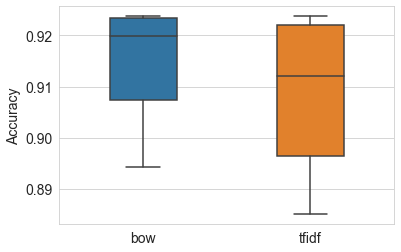

In [92]:
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)

In [93]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test Score with bow features 0.9233333333333333
Test Score with tf-idf features 0.9233333333333333
